In [2]:
import matplotlib.pyplot as plt
import librosa
import torchaudio
import numpy as np
import torch
import torchyin
import src.utils as utils
import src.models as models
import src.spectrograms as spec
import src.transcription

In [3]:
eps = 1e-5
small = 0.1
a = torch.rand(3,4)-small
b = torch.clamp(a, min=eps)
b

tensor([[0.8756, 0.4273, 0.7735, 0.2735],
        [0.7386, 0.6355, 0.1953, 0.1875],
        [0.5574, 0.2493, 0.1277, 0.1017]])

In [4]:
single_note = "data/single_notes"
waveform, sample_rate = torchaudio.load(f"{single_note}/C7.wav")

In [5]:
cqt_spec, _, _ = spec.cqt_spec(waveform, sample_rate, hop_length=256)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=675
  warnings.warn(


### Test creating W from single note audio file

In [6]:
W, freqs = utils.init_W(single_note)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=758
  warnings.warn(
/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=737
  warnings.warn(


### Test running MU iterations on a simple example from init W

In [7]:
waveform_test, sample_rate_test = torchaudio.load("data/test-midi.wav")
cqt_test, times_test, freq_test = spec.cqt_spec(waveform_test, sample_rate_test, 256)

In [8]:
f, t = cqt_test.shape
l = W.shape[1]
n_init_steps = 100

H = utils.init_H(l, t, W, cqt_test, n_init_steps, beta=2)

### Test getting MIDI notes from W

In [9]:
pitches, notes, W, H = utils.W_to_pitch(W, H, freqs)
notes

tensor([48., 53., 84.])

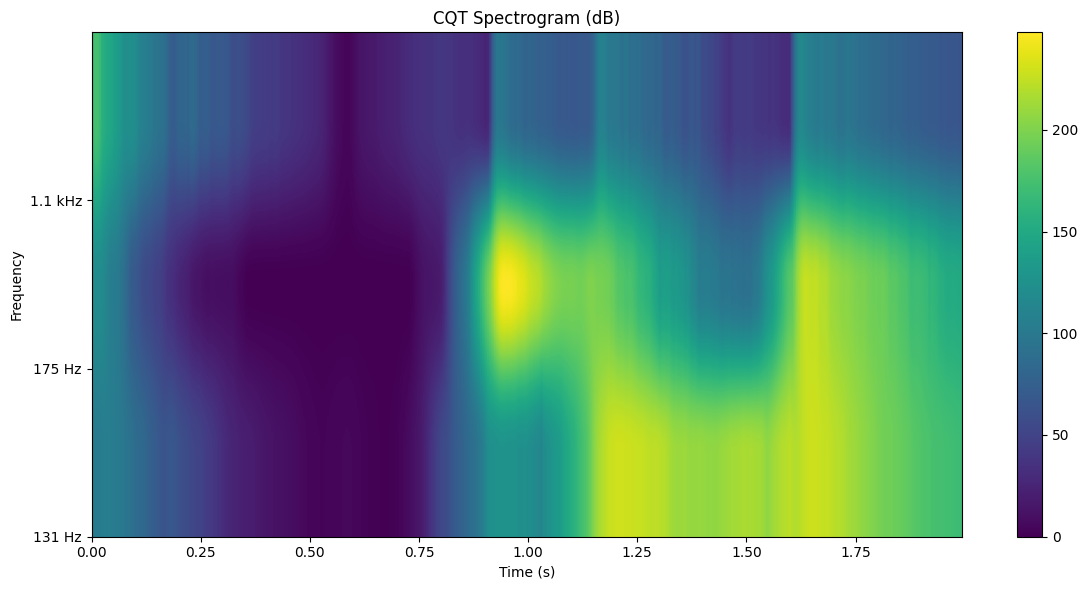

In [10]:
spec.vis_cqt_spectrogram(H, times_test, pitches, 0, 2)

### Test getting MIDI from H

In [11]:
midi = utils.WH_to_MIDI(W, notes, H, threshold=0.04, smoothing_window=5)
for i in range(88):
    if (midi[i,:]>0).any().item():
        print(i)

48
53
84


In [12]:
onset, offset = utils.detect_onsets_offsets(midi)

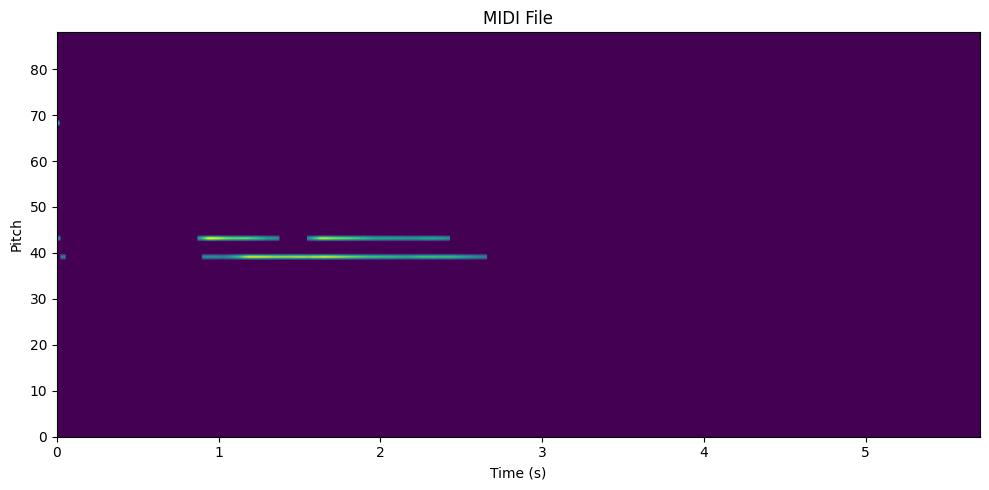

In [16]:
spec.vis_midi(midi, times_test, 0, times_test[-1])

In [ ]:
class feature_object():
    def __init__(self, sr, hop_length, nfft):
        self.sr = sr
        self.hop_length = hop_length
        self.nfft = nfft

ft_obj = feature_object(sr=sample_rate_test, hop_length=256, nfft=1024)

In [ ]:
midi = src.transcription.H_to_activations(W, H, feature_object=ft_obj, threshold=0.01)
midi

In [ ]:
audio_file = "data/take-five-loop.flac"
waveform, sample_rate = torchaudio.load(audio_file)

In [ ]:
y = y[:20000]

In [ ]:
f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=sr, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0, sr=sr)

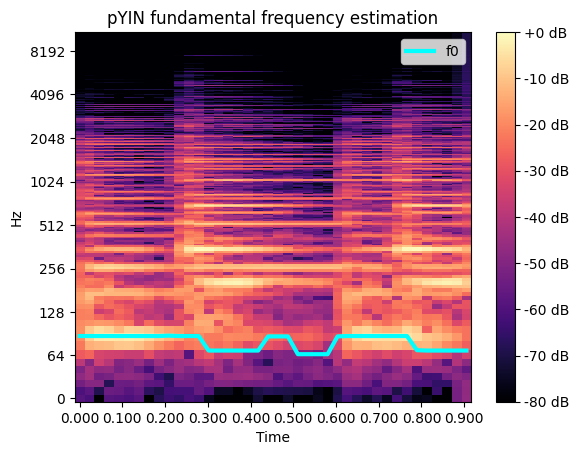

In [ ]:
import matplotlib.pyplot as plt
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')